<a href="https://colab.research.google.com/github/PRomanVl/deep_learning_school/blob/main/semantic%20segmentation/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. 





---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>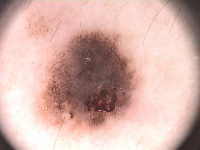</td><td>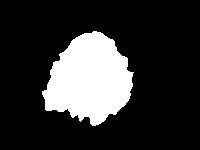</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
! wget https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar

--2021-05-15 15:17:32--  https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t0ichx42vg218hc/PH2Dataset.rar [following]
--2021-05-15 15:17:32--  https://www.dropbox.com/s/raw/t0ichx42vg218hc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc920ae6fadb4a3202235a5d77fb.dl.dropboxusercontent.com/cd/0/inline/BOhb4qTAl8naxV1ABhvmASdl9l8-zHpJr_edEzrvWaQsYBJOOWE_osWPUcSg0H0o--j8993YOTW4-xvgj5ZxRBSgeAWyGOtTopgKimd134_6Lv29PqpFtF9sVFHsPsHZEXUBD3VRfKUFNaHSi73t_Ag_/file# [following]
--2021-05-15 15:17:32--  https://uc920ae6fadb4a3202235a5d77fb.dl.dropboxusercontent.com/cd/0/inline/BOhb4qTAl8naxV1ABhvmASdl9l8-zHpJr_edEzrvWaQsYBJOOWE_osWPUcSg0H0o--j8993YOTW4-xvgj

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

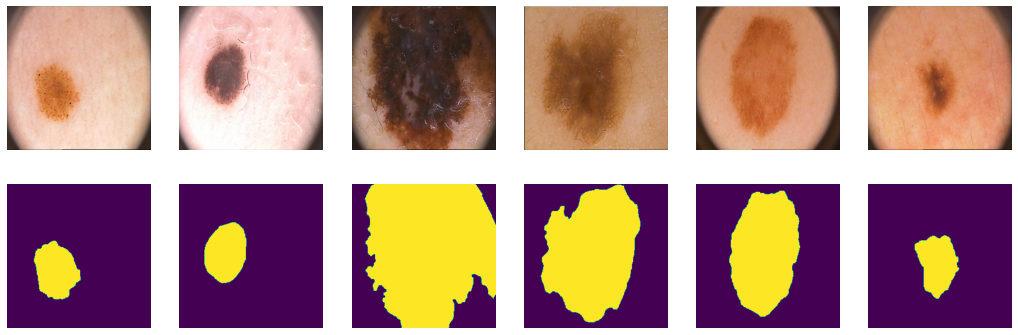

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 30
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet

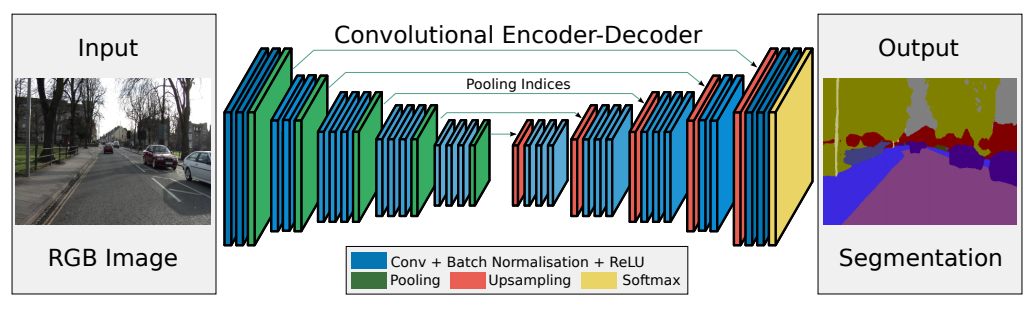

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential( 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential( 
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential( 
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(1,1), stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0) # 16 -> 32
        self.dec_conv0 = nn.Sequential(     
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True)       
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(     
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride=2,  padding=0)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(     
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride=2,  padding=0)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(     
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1))

    def forward(self, x):

        # encoder
        e0, op0 = self.pool0(self.enc_conv0(x))
        e1, op1 = self.pool1(self.enc_conv1(e0))
        e2, op2 = self.pool2(self.enc_conv2(e1))
        e3, op3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder

        dec0 = self.dec_conv0(self.upsample0(b, op3))
        dec1 = self.dec_conv1(self.upsample1(dec0, op2))
        dec2 = self.dec_conv2(self.upsample2(dec1, op1))
        dec3 = self.dec_conv3(self.upsample3(dec2, op0))   # no activation
        return dec3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**
 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    y_pred, y_real = y_pred.to(device), y_real.to(device)
    loss = torch.maximum(y_pred, torch.zeros(1,256,256).to(device)) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))

    return loss.mean()

## Тренировка 


In [ ]:
def train(model, loss_fn, opt, epochs, data_tr, data_val, metric):
    X_val, Y_val = next(iter(data_val))
    train_loss = 0
    val_loss = 0
    score_val = 0
    avg_score = 0
    history = {"val": {"loss":[], 'score':[]}, "train": {"loss":[], 'score':[]}}


    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward

            Y_pred = model(X_batch.to(device))
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            train_loss += loss.item()
            
            #скор на трейне
            sgm = nn.Sigmoid()
            Y_pred = (sgm(Y_pred) >=0.5).float()
            avg_score += metric(Y_pred, Y_batch.to(device)).mean().item()
            avg_score = avg_score/len(data_tr)


        # show intermediate results
        toc = time()
        print('avg_score: %f' % avg_score)
        print('loss: %f' % avg_loss)

        model.eval()  # testing mode


        avg_loss_val = 0
        for X_batch, Y_batch in data_val:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward

            Y_pred = model(X_batch.to(device))
            val_loss = loss_fn(Y_pred, Y_batch) # forward-pass
            val_loss.backward()  # backward-pass

            # calculate loss to show the user
            avg_loss_val += val_loss / len(data_val)

            sgm = nn.Sigmoid()
            Y_pred = (sgm(Y_pred) >=0.5).float()
            score_val += metric(Y_pred, Y_batch.to(device)).mean().item()
            score_val = score_val/len(data_val)
        scheduler.step(val_loss)


        # show intermediate results val
        print('score_val: %f' % score_val)
        print('loss: %f' % avg_loss_val)
        print("--- %s seconds ---" % (toc - tic))

        Y_hat = model(X_val.to(device)).detach().to('cpu')# detach and put into cpu
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0]>0.5, cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Ground truth')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        #сохраняем информацию для построения графиков
        history["train"]['score'].append(avg_score)
        history["val"]["score"].append(score_val)
        history["train"]["loss"].append(avg_loss.item())
        history["val"]["loss"].append(avg_loss_val.item())

    return history

## Инференс


In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_real in data:
        Y_pred = model(X_batch.to(device))
        sgm = nn.Sigmoid()
        Y_pred = sgm((Y_pred) >=0.5).float()
        scores += metric(Y_pred, Y_real.to(device)).mean().item()

    return scores

In [ ]:
def make_graf(history):
    fig = plt.figure(figsize=(15, 9))
    plt.plot(history.get('val').get('loss'), label="val_loss")
    plt.plot(history.get('val').get('score'), label="val_score")
    plt.plot(history.get('train').get('loss'), label="train_loss")
    plt.plot(history.get('train').get('score'), label="train_score")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

## Основной момент: обучение


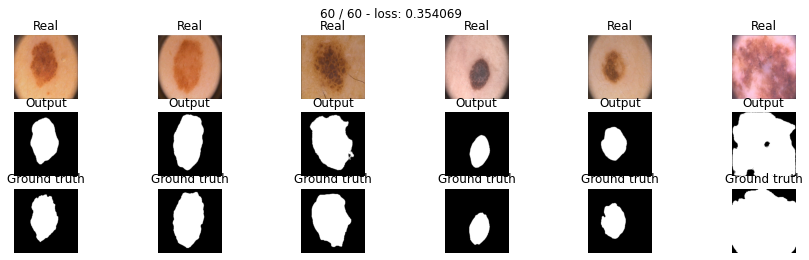

In [ ]:
model_BCE = SegNet().to(device)

max_epochs = 60
opt = torch.optim.AdamW(model_BCE.parameters(), lr=0.0001)
history_BCE = train(model_BCE, bce_loss, opt, max_epochs, data_tr, data_val, iou_pytorch)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь 

 В данном разделе вам потребуется имплементировать две функции потерь:



**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$



In [ ]:
def dice_loss(y_pred, y_real):
    smooth = 1e-10
    y_pred = torch.sigmoid(y_pred)
    num = 2.*(y_real*y_pred + smooth).sum()
    den = (y_real+y_pred + smooth).sum()
    res = 1 - num/den
    return res.mean()

Проводим тестирование:

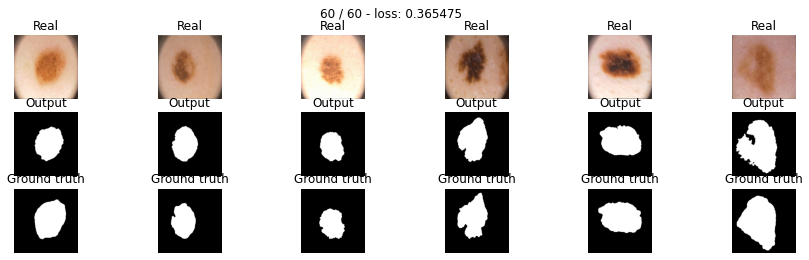

In [ ]:
model_dice = SegNet().to(device)
optimizer = torch.optim.AdamW(model_dice.parameters(), lr=0.001)
max_epochs = 60
history_DICE = train(model_dice, dice_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):


    y_pred = torch.sigmoid(y_pred)
    pt = y_real*y_pred + (1 - y_real)*(1-y_pred)
    res = -(1-pt)**gamma*torch.log(pt+eps)#+(1-y_real)*torch.log(1-pt)
    return res.mean()

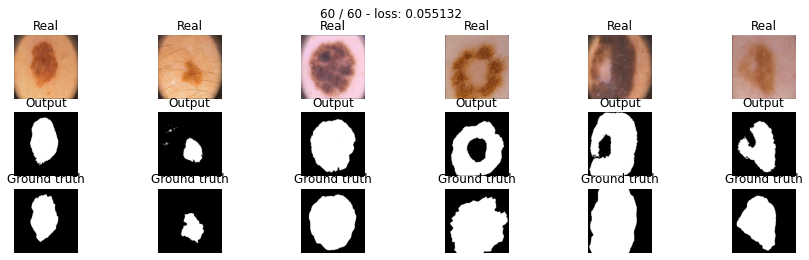

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 60
optimizer = torch.optim.AdamW(model_focal.parameters(), lr=0.001)
history_focal = train(model_focal, focal_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)

In [ ]:
#    Lovasz-Softmax
#    https://arxiv.org/abs/1705.08790

def lovasz_loss(y_pred, y_real):

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    signs = 2 * y_real.float() - 1
    errors = (1 - y_pred * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data

    intersection = y_real[perm].sum() - y_real[perm].float().cumsum(0)
    union = y_real[perm].sum() + (1 - y_real[perm]).float().cumsum(0)
    grad = 1. - intersection / union
    loss = torch.dot(F.relu(errors_sorted), Variable(grad)) * 1e-5
    return loss

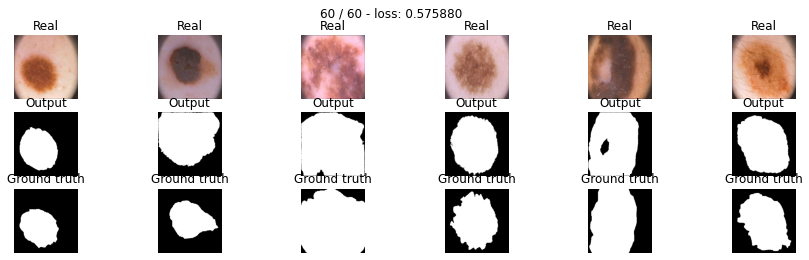

In [ ]:
model_lova = SegNet().to(device)

max_epochs = 60
optimizer = torch.optim.AdamW(model_lova.parameters(), lr=0.001)
history_lova = train(model_lova, lovasz_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)

In [ ]:
#Тверский лосс

def tversky_loss(y_pred, y_real, beta = 0.6):
    y_pred = torch.sigmoid(y_pred)
    smooth = 1e-8
    y_real_pos = torch.flatten(y_real)
    y_pred_pos = torch.flatten(y_pred)
    real_pos = torch.sum(y_real_pos * y_pred_pos)
    false_neg = torch.sum(y_real_pos * (1 - y_pred_pos))
    false_pos = torch.sum((1 - y_real_pos)*y_pred_pos)
    res = 1 - (real_pos + smooth)/(real_pos + beta*false_neg + (1 - beta)*false_pos + smooth)
    return res 

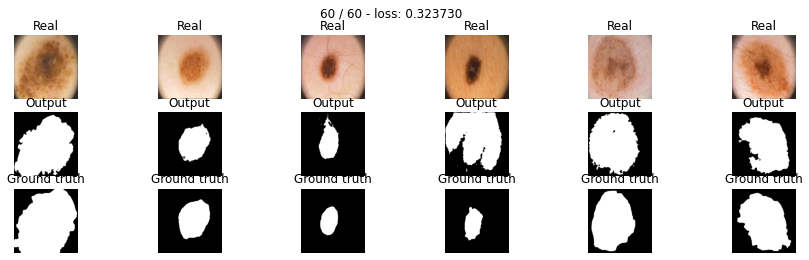

In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 60
optimizer = torch.optim.Adam(model_tversky.parameters())
history_TVERSKY = train(model_tversky, tversky_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)

## U-Net

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()


        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))      
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)) 
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)) 

        self.upsample4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)            
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)) 

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)            
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=768, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)) 
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)) 
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=32, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        self.conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)


    def forward(self, x):
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))
        e4 = self.enc_conv4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.upsample4(b)
        d3 = self.dec_conv4(torch.cat((d4, e4), dim=1))
        d3 = self.upsample3(d3)
        d3 = self.dec_conv3(torch.cat((d3, e3), dim=1))
        d2 = self.upsample2(d3)
        d2 = self.dec_conv2(torch.cat((d2, e2), dim=1))
        d1 = self.upsample1(d2)
        d1 = self.dec_conv1(torch.cat((d1, e1), dim=1))
        d0 = self.upsample0(d1)
        d0 = self.dec_conv0(torch.cat((d0, e0), dim=1))
        return self.conv(d0)


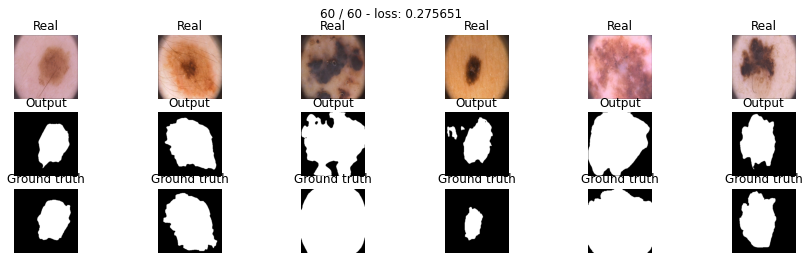

In [ ]:
model_BCE_unet = UNet().to(device)

max_epochs = 60
optimizer = optim.RMSprop(model_BCE_unet.parameters(), lr=0.00001, weight_decay=1e-8, momentum=0.9)
history_BCE_UNET = train(model_BCE_unet, bce_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)

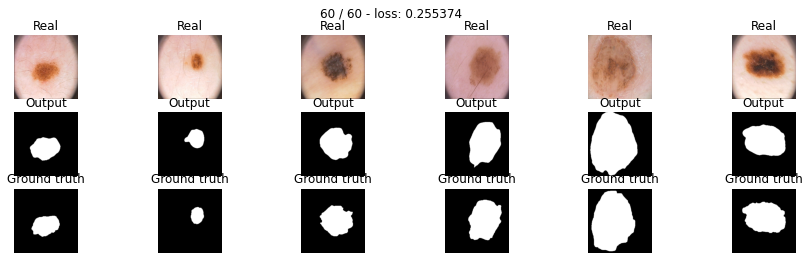

In [ ]:
unet_DICE_model = UNet().to(device)

max_epochs = 60
optimizer = optim.RMSprop(unet_DICE_model.parameters(), lr=0.000005, weight_decay=1e-8, momentum=0.9)
hystory_DICE_UNET = train(unet_DICE_model, dice_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)


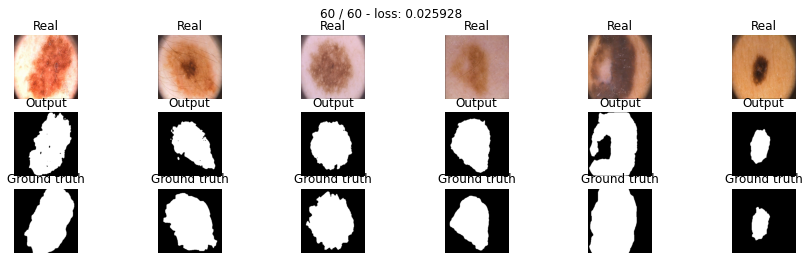

In [ ]:
model_FOCAL_unet = UNet().to(device)

max_epochs = 60
optimizer = optim.RMSprop(model_FOCAL_unet.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
history_FOCAL_UNET = train(model_FOCAL_unet, focal_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)

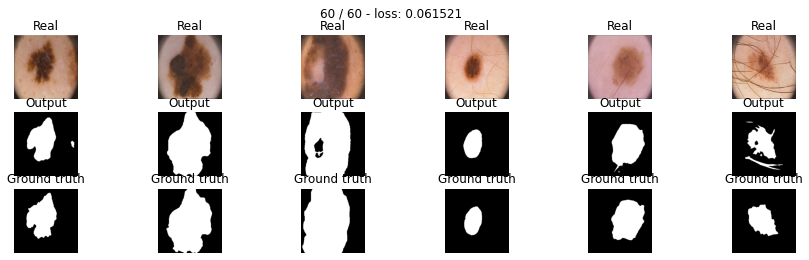

In [ ]:
model_LOVA_unet = UNet().to(device)

max_epochs = 60
optimizer = optim.RMSprop(model_LOVA_unet.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
hystory_LOVA_UNET = train(model_LOVA_unet, lovasz_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)


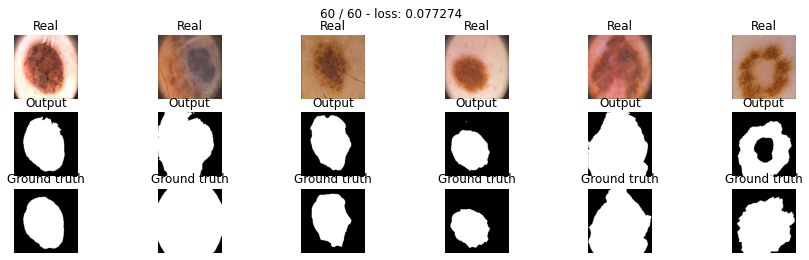

In [ ]:
model_TVERSKY_unet = UNet().to(device)

max_epochs = 60
optimizer = optim.RMSprop(model_TVERSKY_unet.parameters(), lr=0.01, weight_decay=1e-8, momentum=0.9)
history_TVERSKY_UNET = train(model_TVERSKY_unet, tversky_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()


        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size = (2, 2), stride = 2, padding=0)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))      
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size = (2, 2), stride = 2, padding=0)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)) 
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size = (2, 2), stride = 2, padding=0)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)) 
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size = (2, 2), stride = 2, padding=0)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)) 


        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)            
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)) 
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)) 
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.upsample0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size = (3, 3), stride = 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        self.conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)


    def forward(self, x):
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        b = self.bottleneck(self.pool3(e3))

        d3 = self.upsample3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec_conv3(d3)
        d2 = self.upsample2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec_conv2(d2)
        d1 = self.upsample1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec_conv1(d1)
        d0 = self.upsample0(d1)
        d0 = torch.cat((d0, e0), dim=1)
        d0 = self.dec_conv0(d0)
        return self.conv(d0)


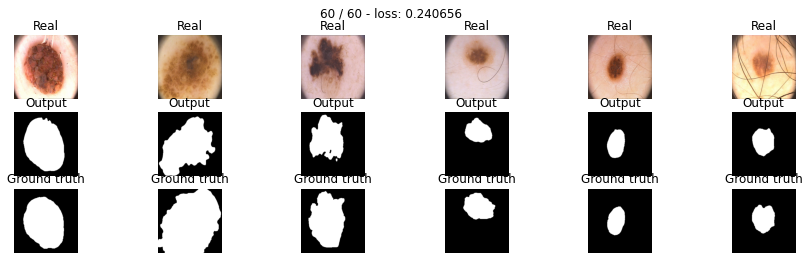

In [ ]:
unet2_model = UNet2().to(device)

max_epochs = 60
optimizer = optim.RMSprop(unet2_model.parameters(), lr=0.00001, weight_decay=1e-8, momentum=0.9)
hystory_BCE_unet2 = train(unet2_model, bce_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)


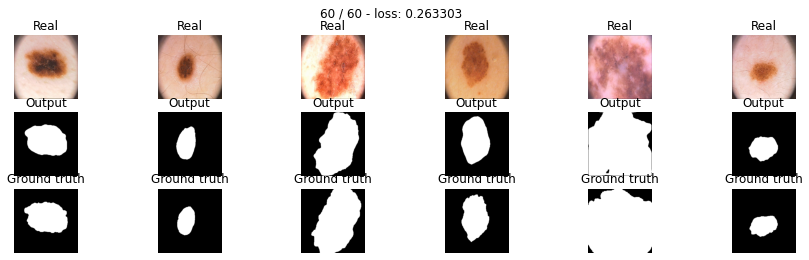

In [ ]:
unet2_DICE_model = UNet2().to(device)

max_epochs = 60
optimizer = optim.RMSprop(unet2_DICE_model.parameters(), lr=0.000005, weight_decay=1e-8, momentum=0.9)
hystory_DICE_unet2 = train(unet2_DICE_model, dice_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)


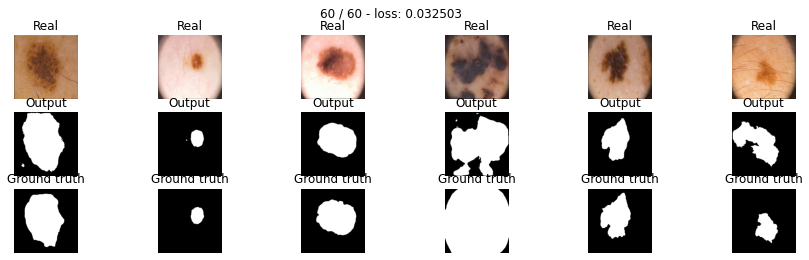

In [ ]:
unet2_FOCAL_model = UNet2().to(device)

max_epochs = 60
optimizer = optim.RMSprop(unet2_FOCAL_model.parameters(), lr=0.00001, weight_decay=1e-8, momentum=0.9)
hystory_FOCAL_unet2 = train(unet2_FOCAL_model, focal_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)


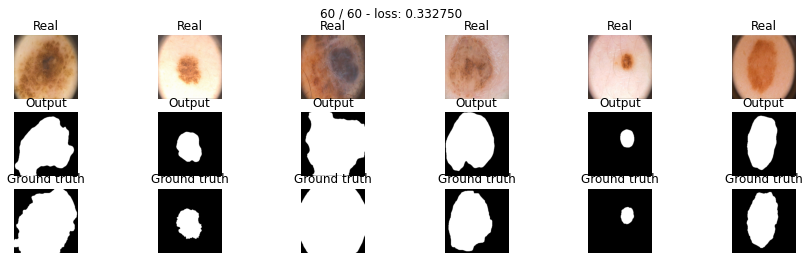

In [ ]:
unet2_LOVA_model = UNet2().to(device)

max_epochs = 60
optimizer = optim.RMSprop(unet2_LOVA_model.parameters(), lr=0.00001, weight_decay=1e-8, momentum=0.9)
hystory_LOVA_unet2 = train(unet2_LOVA_model, lovasz_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)

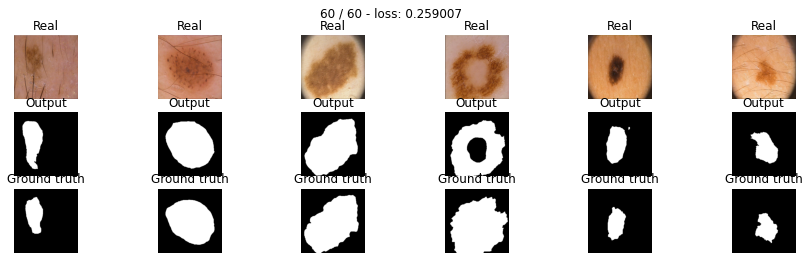

In [ ]:
unet2_TVERSKY_model = UNet2().to(device)

max_epochs = 60
optimizer = optim.RMSprop(unet2_TVERSKY_model.parameters(), lr=0.00001, weight_decay=1e-8, momentum=0.9)
hystory_TVERSKY_unet2 = train(unet2_TVERSKY_model, bce_loss, optimizer, max_epochs, data_tr, data_val, iou_pytorch)


# Отчет: 


In [ ]:
def eval_score3F(history1, history2, history3):
    fig = plt.figure(figsize=(15, 9))
    plt.plot(history1.get('val').get('score'), label="val_score BCE_SegNet")
    plt.plot(history2.get('val').get('score'), label="val_score BCE_Unet")
    plt.plot(history3.get('val').get('score'), label="val_score BCE_Unet2")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [ ]:
def eval_train_loss5F(history1, history2, history3, history4, history5):
    fig = plt.figure(figsize=(15, 9))
    plt.plot(history1.get('train').get('loss'), label="train_loss BCE")
    plt.plot(history2.get('train').get('loss'), label="train_loss DICE")
    plt.plot(history3.get('train').get('loss'), label="train_loss FOCAL")
    plt.plot(history4.get('train').get('loss'), label="train_loss TVERSKY")
    plt.plot(history4.get('train').get('loss'), label="train_loss LOVASZ")    
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [ ]:
def eval_score5F(history1, history2, history3, history4, history5):
    fig = plt.figure(figsize=(15, 9))
    plt.plot(history1.get('val').get('score'), label="val_score BCE")
    plt.plot(history2.get('val').get('score'), label="val_score DICE")
    plt.plot(history3.get('val').get('score'), label="val_score FOCAL")
    plt.plot(history4.get('val').get('score'), label="val_score TVERSKY")
    plt.plot(history4.get('val').get('score'), label="train_score LOVASZ")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

# С каким лоссом лучше будет работать Segnet?

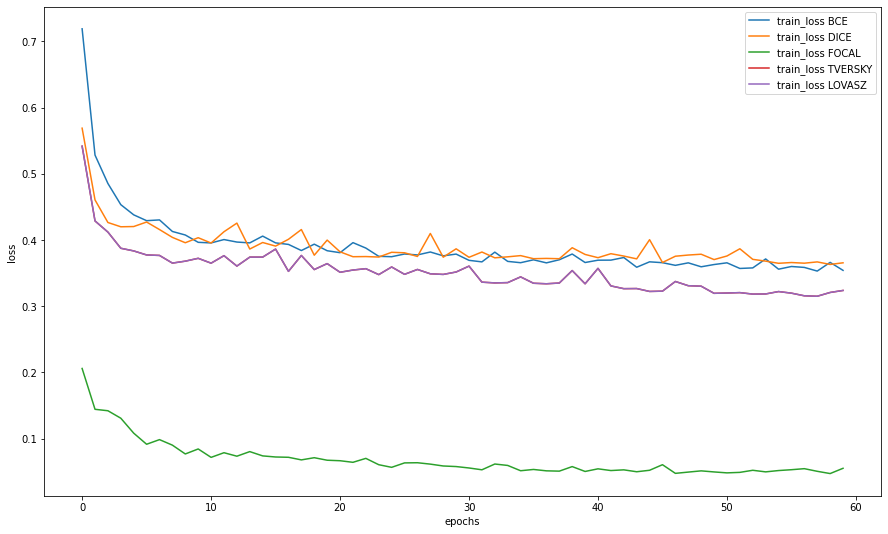

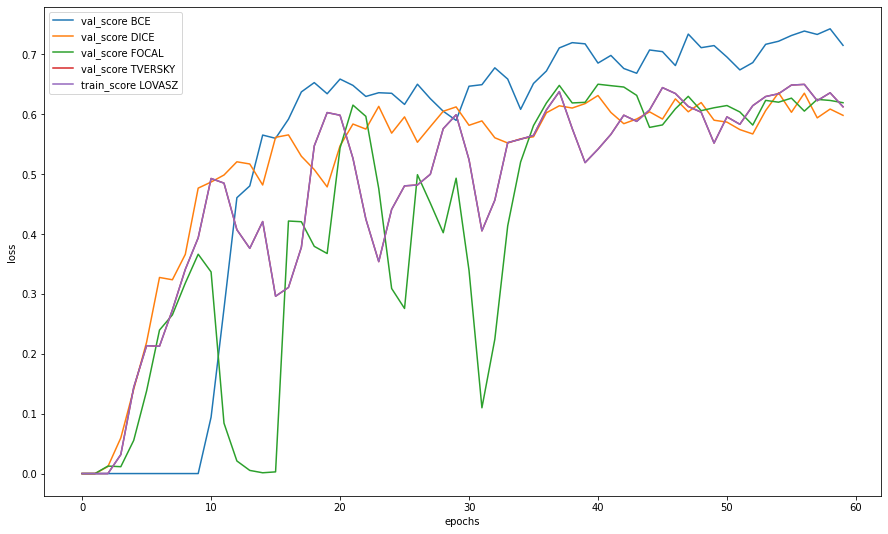

In [ ]:
eval_train_loss5F(history_BCE, history_DICE, history_focal, history_TVERSKY, hystory_LOVA_UNET)
eval_score5F(history_BCE, history_DICE, history_focal, history_TVERSKY, hystory_LOVA_UNET)

При обучении SegNet очевидных преимуществ одного loss'a от другого выявлено не было

# С каким лоссом лучше будет работать U-net?

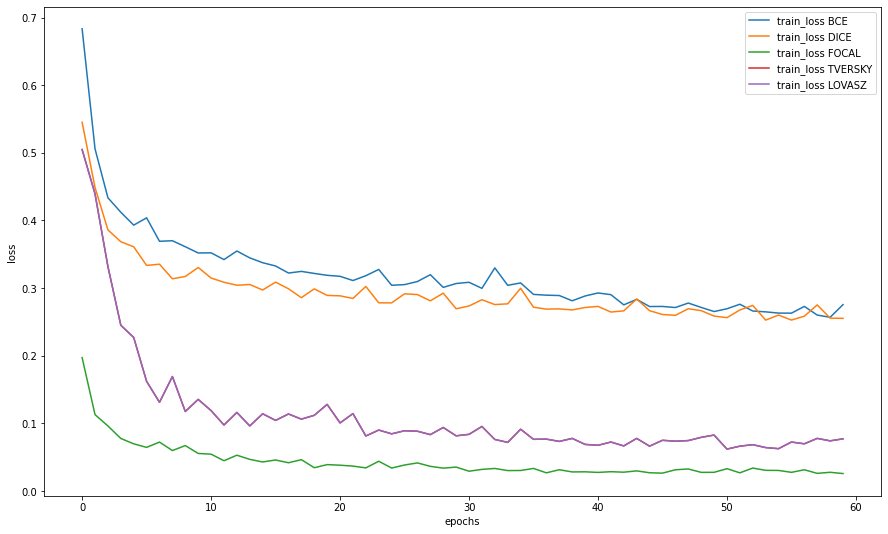

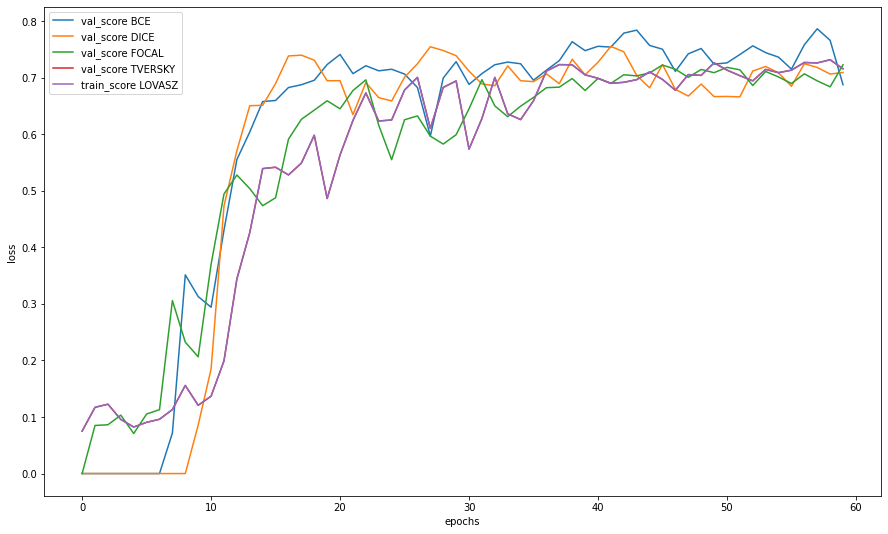

In [ ]:
eval_train_loss5F(history_BCE_UNET, hystory_DICE_unet, history_FOCAL_UNET, history_TVERSKY_UNET, hystory_LOVA_UNET)
eval_score5F(history_BCE_UNET, hystory_DICE_unet, history_FOCAL_UNET, history_TVERSKY_UNET, hystory_LOVA_UNET)

Для Unet'a при одинаковом lr = 0.001 все лоссы приходят к одному и тому же скору примерно за одно и то же количество эпох. Но если пытаться подобрать подходящий lr(или настроить шедулер) то появляется разница, при этом довольно существенная, сказать однозначно какой лосс для этой задачи подходит лучше я не могу.

# С каким лоссом лучше будет работать U-net2?

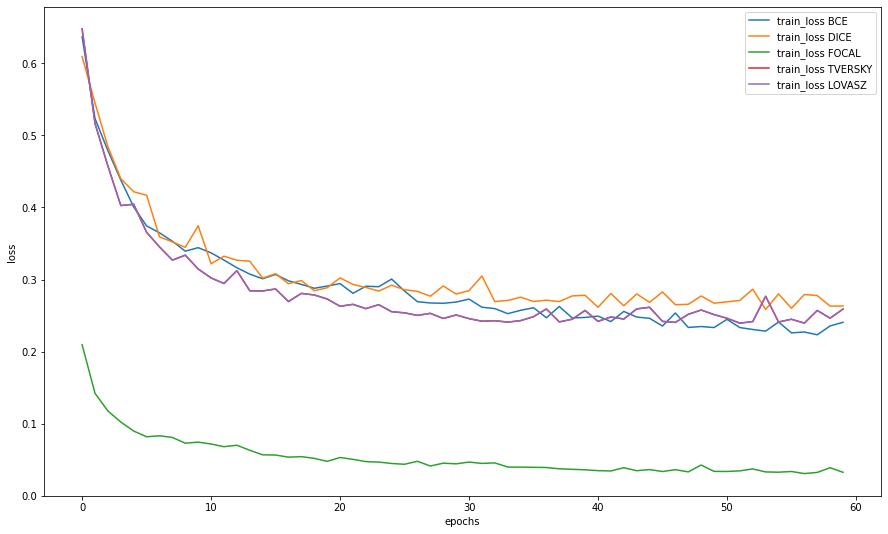

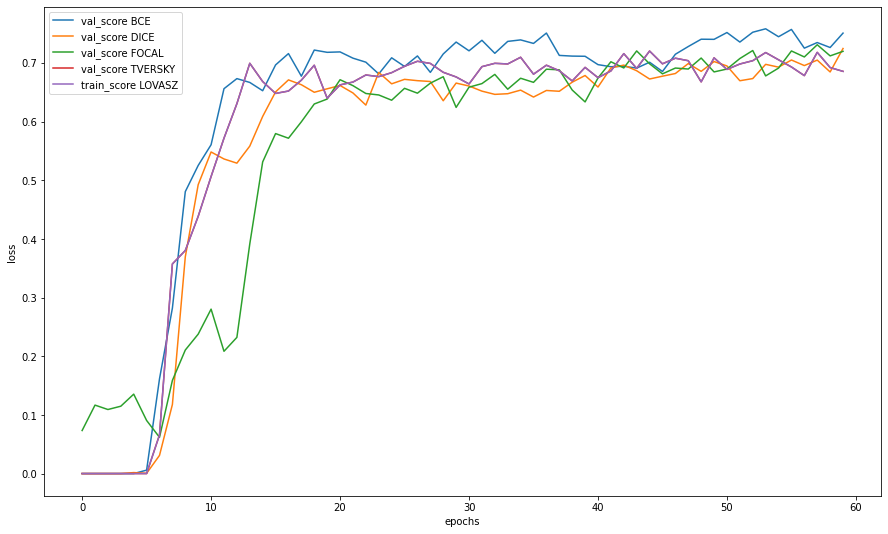

In [ ]:
eval_train_loss5F(hystory_BCE_unet2, hystory_DICE_unet2, hystory_FOCAL_unet2, hystory_TVERSKY_unet2, hystory_LOVA_unet2)
eval_score5F(hystory_BCE_unet2, hystory_DICE_unet2, hystory_FOCAL_unet2, hystory_TVERSKY_unet2, hystory_LOVA_unet2)

И на Unet разницы между loss'ами не получилось

# Какая из моделей будет лучше работать на BCE loss

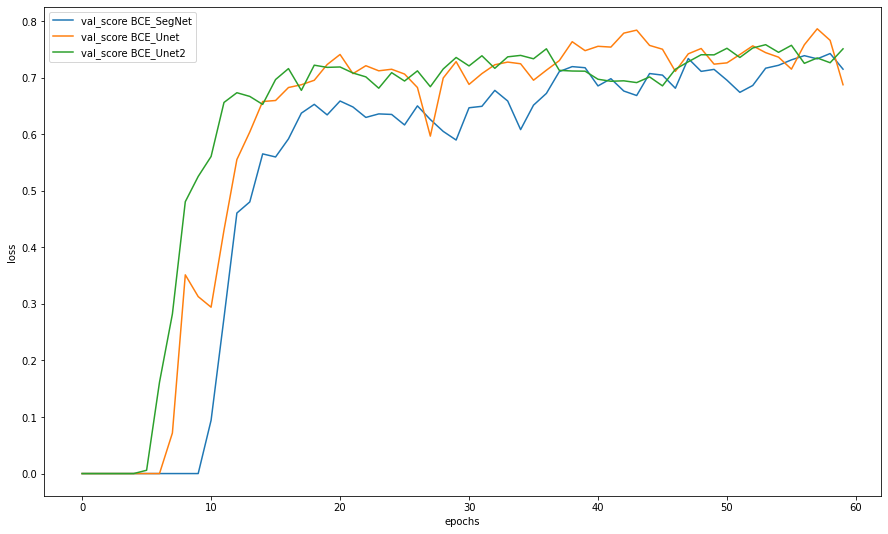

In [ ]:
eval_score3F(history_BCE, history_BCE_UNET, hystory_BCE_unet2)

In [ ]:
num_params = sum(p.numel() for p in model_BCE.parameters())
print("Количество параметров SegNet :%f" % num_params)

num_params = sum(p.numel() for p in model_BCE_unet.parameters())
print("Количество параметров   UNet :%f" % num_params)

num_params = sum(p.numel() for p in unet2_model.parameters())
print("Количество параметров  UNet2 :%f" % num_params)

Количество параметров SegNet :10986691.000000
Количество параметров   UNet :31193089.000000
Количество параметров  UNet2 :8114625.000000


Таким образом при меньшем количеством параметров UNet2 работает лучше в данном случае: быстрее обучается и доходит до лучшего качества, при этом затрачивая меньшее количество времени(время замеряется в трейне):

* SegNet - 1 сек на эпоху
* U-Net - 0.85 сек на эпоху
* U-Net2 - 0.7 сек на эпоху